# Implementing self-attention with trainable weights

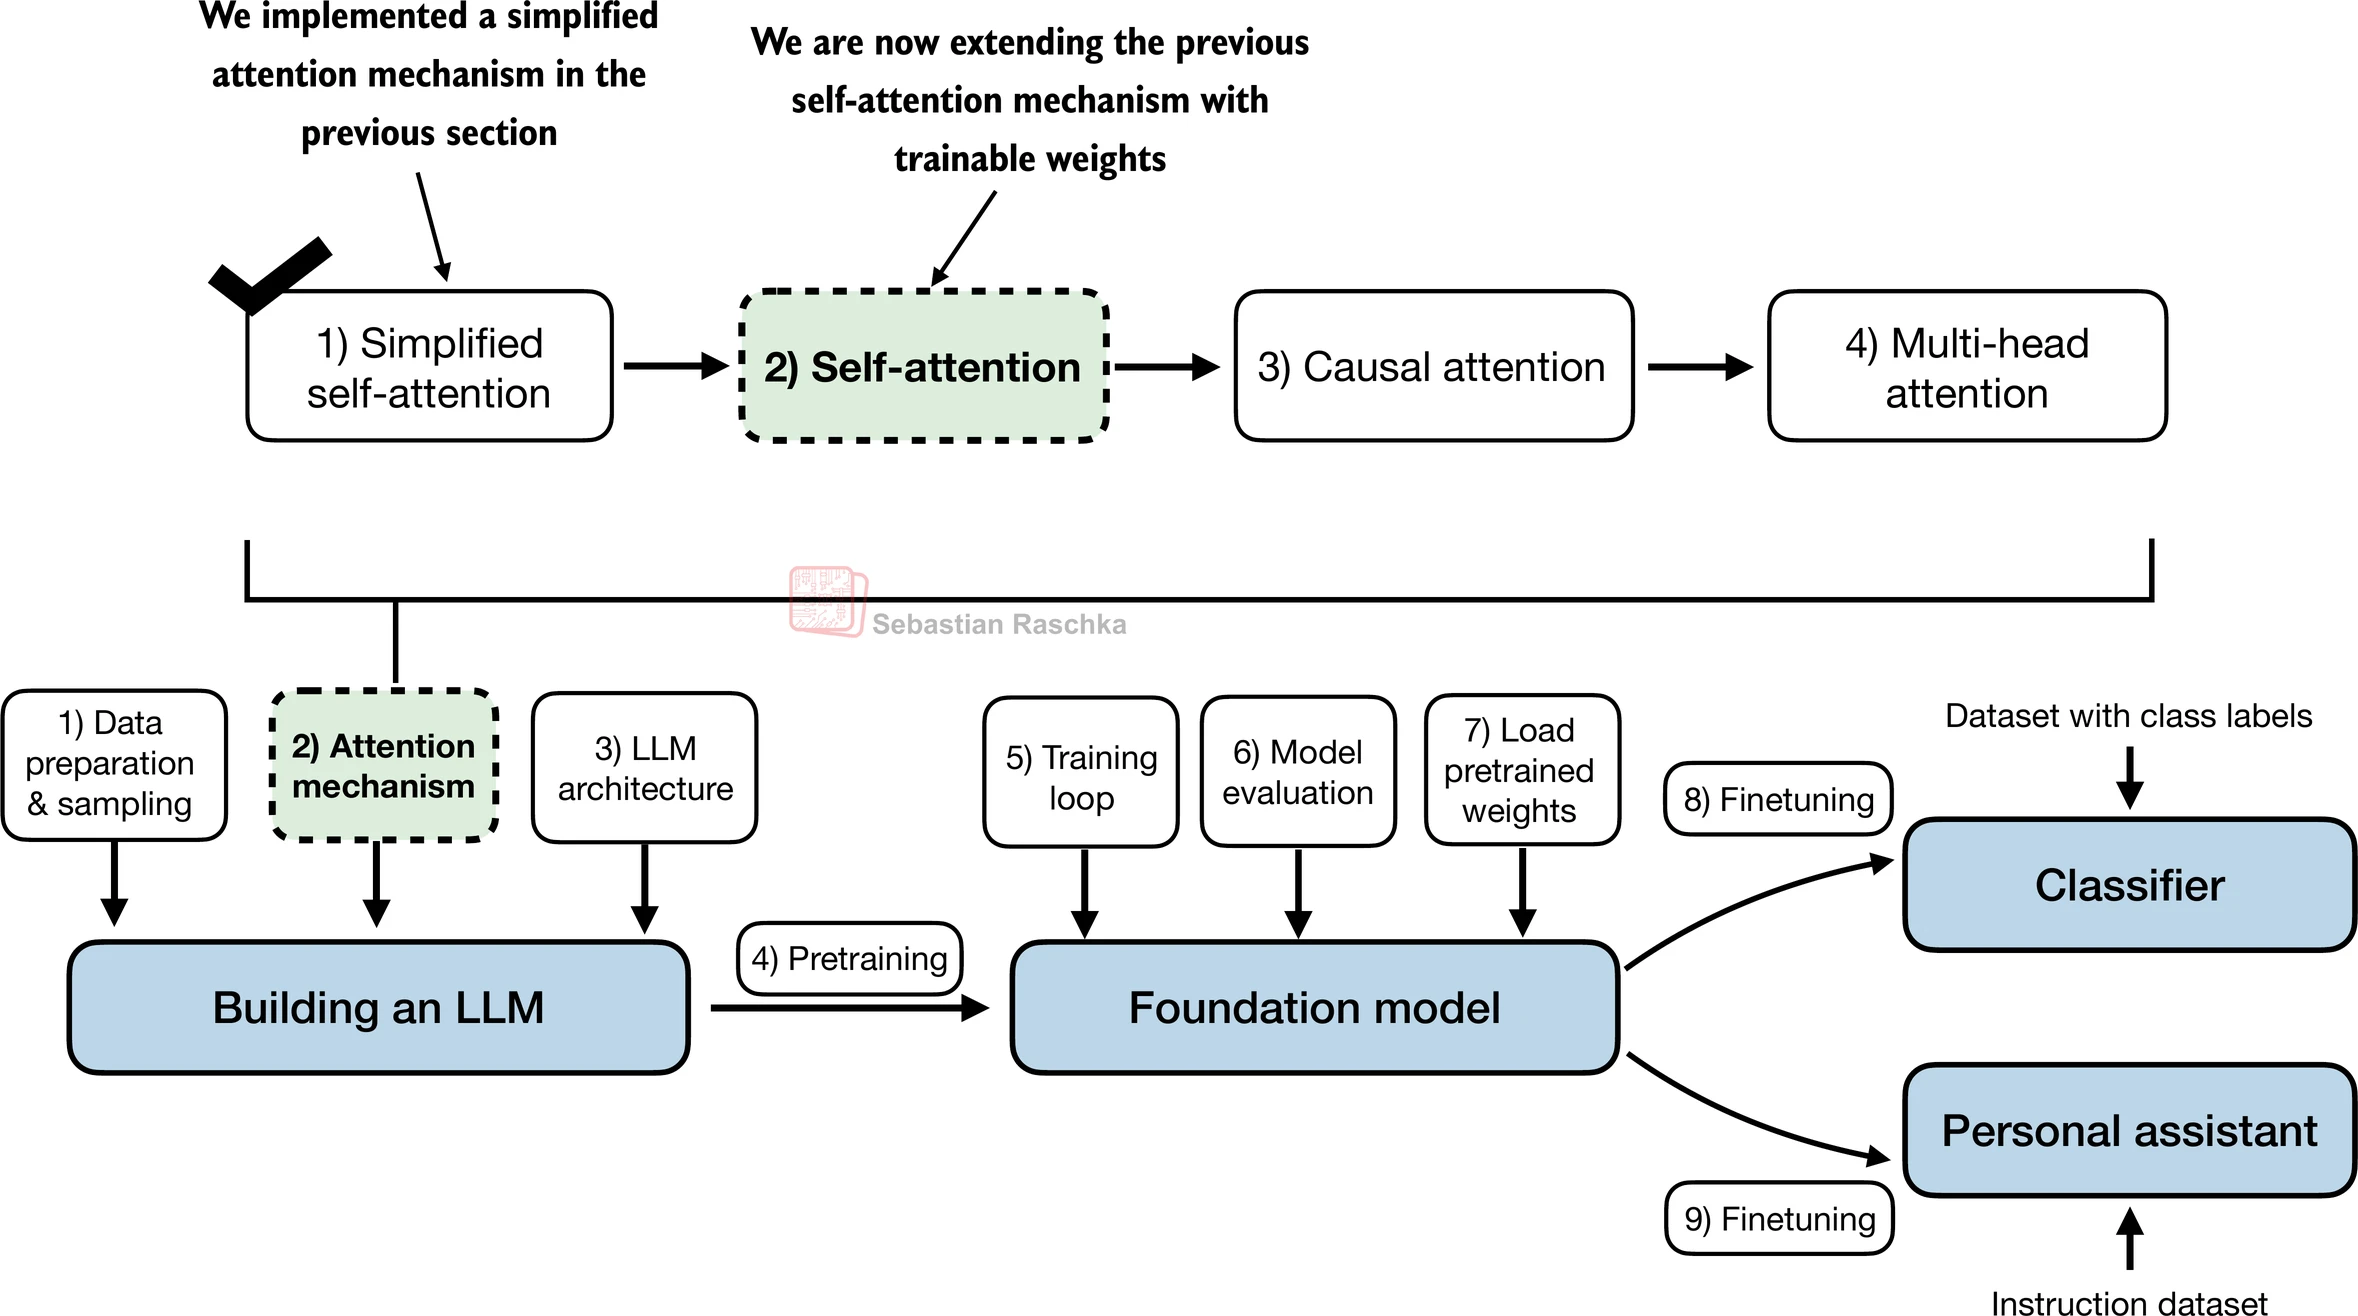

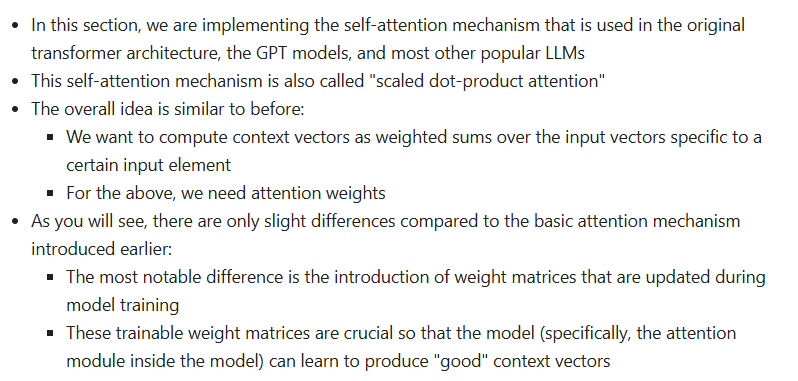

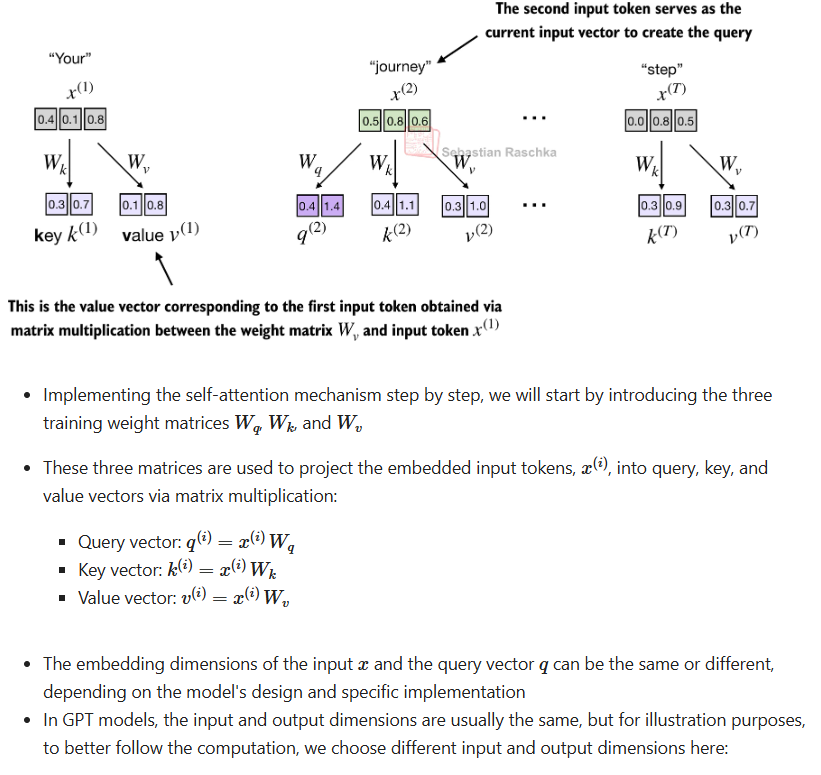
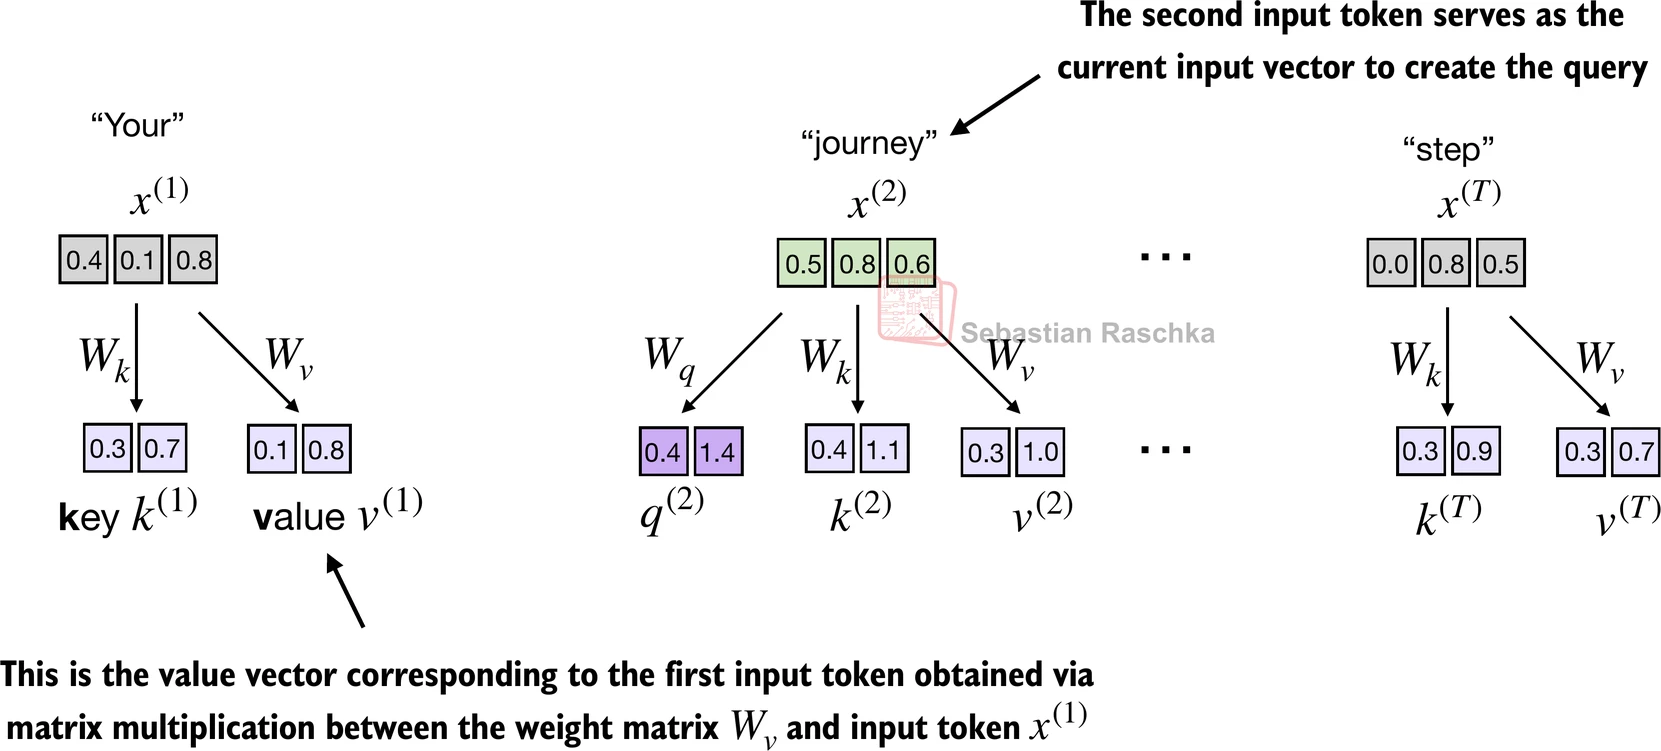

In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

<div class="alert alert-block alert-info">
    
#A The second input element

#B The input embedding size, d=3


#C The output embedding size, d_out=2

</div>

In [2]:
x_2 = inputs[1]  # A
d_in = inputs.shape[1]  # B
d_out = 2 # C

<div class="alert alert-block alert-info">
    
Note that in GPT-like models, the input and output dimensions are usually the same. 

But for illustration purposes, to better follow the computation, we choose different input (d_in=3)
and output (d_out=2) dimensions here.

</div>

<div class="alert alert-block alert-success">

Next, we initialize the three weight matrices Wq, Wk and Wv

</div>

In [3]:
torch.manual_seed(123)
w_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
w_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
w_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [4]:
print(w_query)

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [5]:
print(w_key)

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])


In [6]:
print(w_value)

Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


<div class="alert alert-block alert-info">
    
Note that we are setting requires_grad=False to reduce clutter in the outputs for
illustration purposes. 

If we were to use the weight matrices for model training, we
would set requires_grad=True to update these matrices during model training.

</div>

<div class="alert alert-block alert-success">

Next, we compute the query, key, and value vectors as shown earlier
</div>

In [7]:
query_2 = x_2 @ w_query
key_2 = x_2 @ w_key
value_2 = x_2 @ w_value

print(query_2)


tensor([0.4306, 1.4551])


<div class="alert alert-block alert-info">
    
As we can see based on the output for the query, this results in a 2-dimensional vector. 

This is because: we set the number of columns of the corresponding weight matrix, via d_out, to 2:

</div>

<div class="alert alert-block alert-success">

Even though our temporary goal is to only compute the one context vector z(2),  we still
require the key and value vectors for all input elements. 

This is because they are involved in computing the attention weights with respect to the query q(2)
</div>

<div class="alert alert-block alert-success">

We can obtain all keys and values via matrix multiplication:
</div>

In [8]:
keys = inputs @ w_key
values = inputs @ w_value
queries = inputs @ w_query

print("Keys.shape: ", keys.shape)
print("values.shape: ", values.shape)
print("queries.shape: ", queries.shape)

Keys.shape:  torch.Size([6, 2])
values.shape:  torch.Size([6, 2])
queries.shape:  torch.Size([6, 2])


<div class="alert alert-block alert-info">
    
As we can tell from the outputs, we successfully projected the 6 input tokens from a 3D
onto a 2D embedding space:

</div>

<div class="alert alert-block alert-success">

First, let's compute the attention score ω22</div>

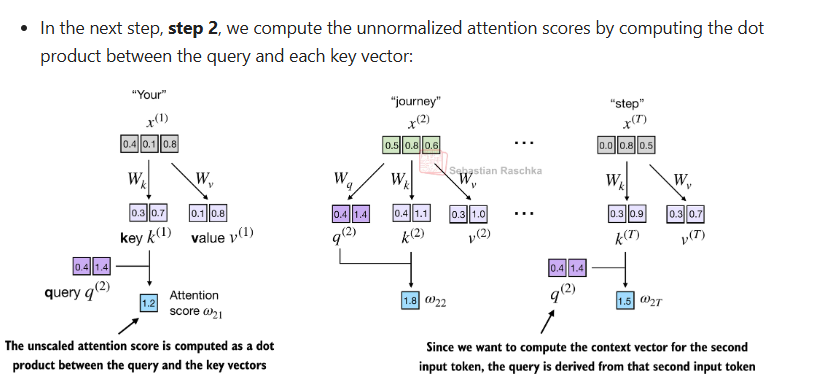
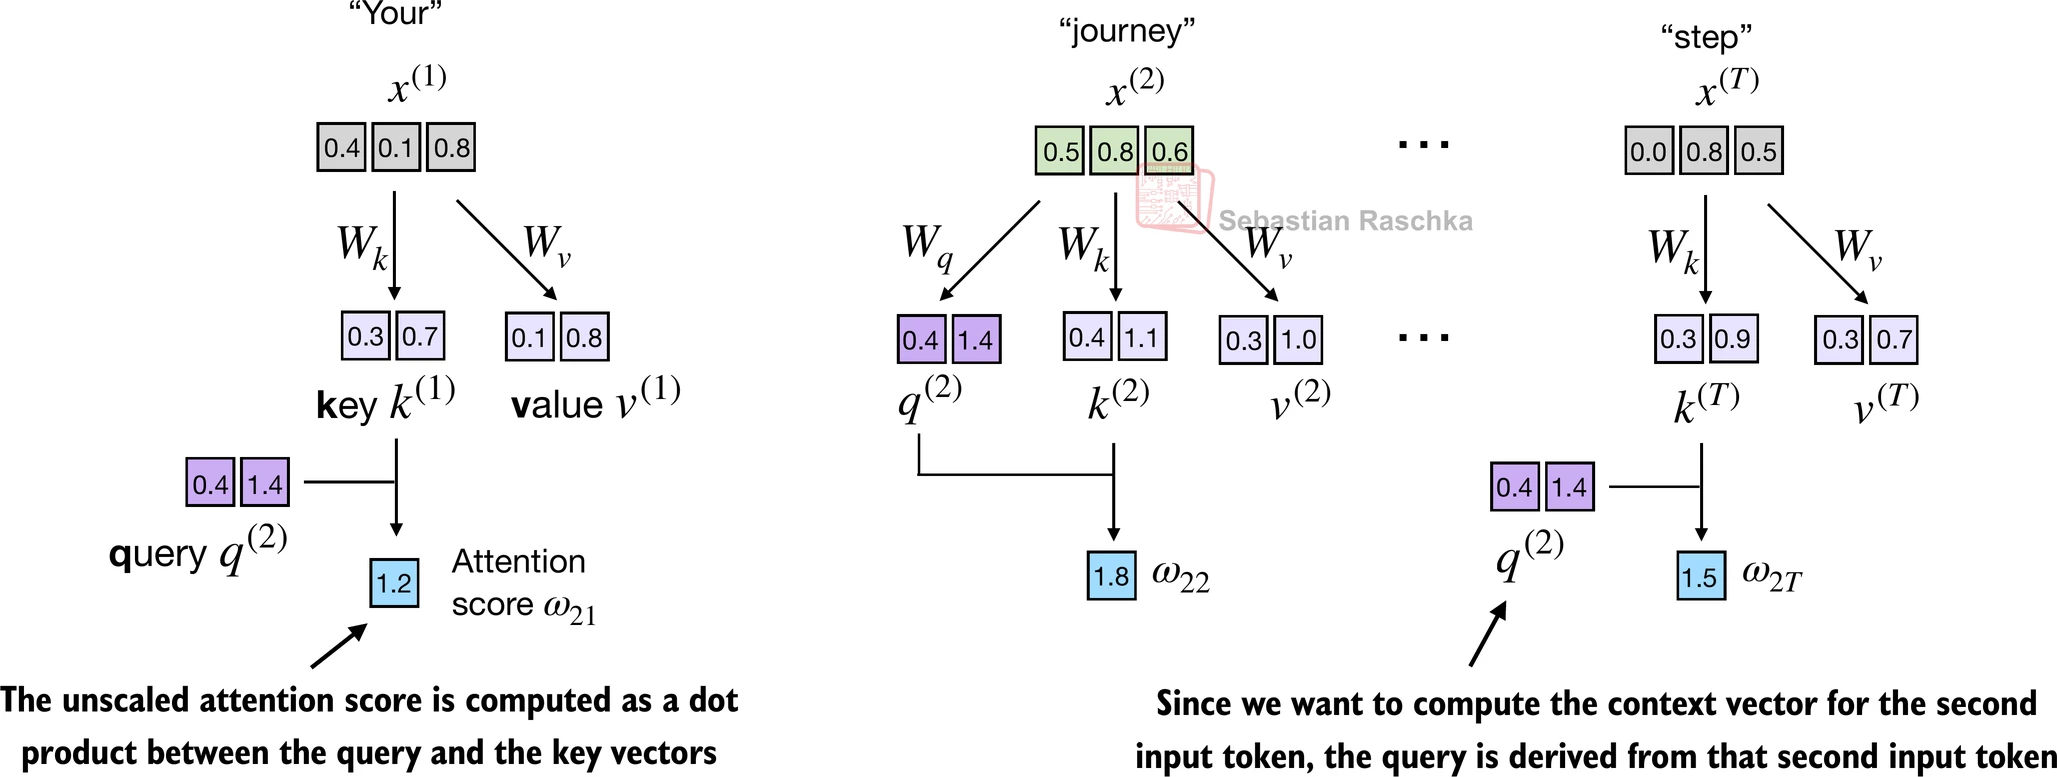

In [9]:
keys_2 = keys[1]  # A
attention_score_22 = query_2.dot(keys_2)
print(attention_score_22)

tensor(1.8524)


<div class="alert alert-block alert-success">
Again, we can generalize this computation to all attention scores via matrix multiplication:</div>

In [10]:
attention_score_2 = query_2 @ keys.T # All the attention score of the given query
print(attention_score_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [11]:
attention_score = queries @ keys.T     # omega
print(attention_score)

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


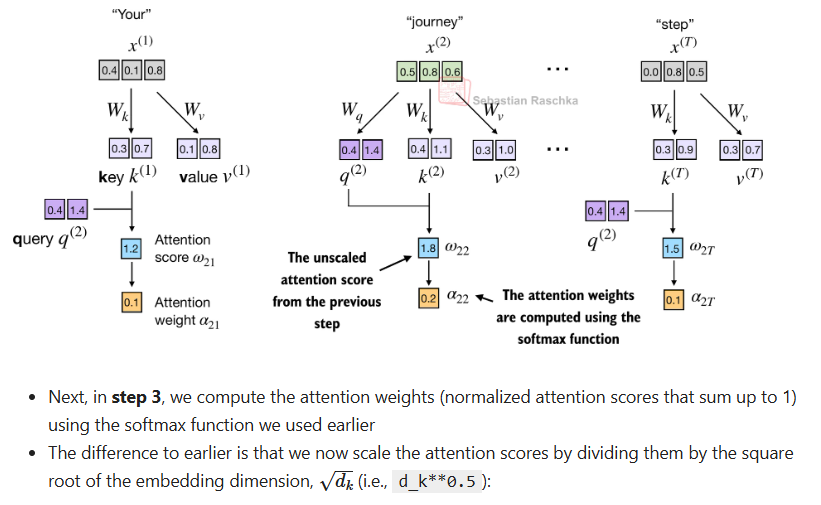

In [12]:
d_k = keys.shape[-1]
attention_weights_2 = torch.softmax(attention_score / d_k ** 0.5, dim = -1)
print(attention_weights_2)
print(d_k)

tensor([[0.1551, 0.2104, 0.2059, 0.1413, 0.1074, 0.1799],
        [0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
        [0.1503, 0.2256, 0.2192, 0.1315, 0.0914, 0.1819],
        [0.1591, 0.1994, 0.1962, 0.1477, 0.1206, 0.1769],
        [0.1610, 0.1949, 0.1923, 0.1501, 0.1265, 0.1752],
        [0.1557, 0.2092, 0.2048, 0.1419, 0.1089, 0.1794]])
2


WHY DIVIDE BY SQRT (DIMENSION)

<div class="alert alert-block alert-warning">

Reason 1: For stability in learning

The softmax function is sensitive to the magnitudes of its inputs. When the inputs are large, the differences between the exponential values of each input become much more pronounced. This causes the softmax output to become "peaky," where the highest value receives almost all the probability mass, and the rest receive very little.

In attention mechanisms, particularly in transformers, if the dot products between query and key vectors become too large (like multiplying by 8 in this example), the attention scores can become very large. This results in a very sharp softmax distribution, making the model overly confident in one particular "key." Such sharp distributions can make learning unstable,
    
</div>

In [13]:
import torch 

# define the tensor 

tensor = torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])

# Apply softmax without scaling

softmax_result = torch.softmax(tensor, dim = -1)
print("Softmax without scalling:", softmax_result)

# Multiplying the tensor by 8 and then apply softmax

scaled_tensor = tensor * 8
softmax_scaled_result = torch.softmax(scaled_tensor, dim = -1)
print("Softmax after scalling (tensor *8):", softmax_scaled_result)


Softmax without scalling: tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
Softmax after scalling (tensor *8): tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


BUT WHY SQRT?

<div class="alert alert-block alert-warning">

Reason 2: To make the variance of the dot product stable

The dot product of  Q and K increases the variance because multiplying two random numbers increases the variance.

The increase in variance grows with the dimension. 

Dividing by sqrt (dimension) keeps the variance close to 1
    
</div>

In [14]:
import numpy as np

# Function to compute variance before and after scaling
def compute_variance(dim, num_trials=1000):
    dot_products = []
    scaled_dot_products = []

    # Generate multiple random vectors and compute dot products
    for _ in range(num_trials):
        q = np.random.randn(dim)
        k = np.random.randn(dim)
        
        # Compute dot product
        dot_product = np.dot(q, k)
        dot_products.append(dot_product)
        
        # Scale the dot product by sqrt(dim)
        scaled_dot_product = dot_product / np.sqrt(dim)
        scaled_dot_products.append(scaled_dot_product)
    
    # Calculate variance of the dot products
    variance_before_scaling = np.var(dot_products)
    variance_after_scaling = np.var(scaled_dot_products)

    return variance_before_scaling, variance_after_scaling

# For dimension 5
variance_before_5, variance_after_5 = compute_variance(5)
print(f"Variance before scaling (dim=5): {variance_before_5}")
print(f"Variance after scaling (dim=5): {variance_after_5}")

# For dimension 20
variance_before_100, variance_after_100 = compute_variance(100)
print(f"Variance before scaling (dim=100): {variance_before_100}")
print(f"Variance after scaling (dim=100): {variance_after_100}")



Variance before scaling (dim=5): 4.866742315212578
Variance after scaling (dim=5): 0.9733484630425155
Variance before scaling (dim=100): 107.99736918436463
Variance after scaling (dim=100): 1.079973691843646


<div class="alert alert-block alert-success">
    
We now compute the context vector as a weighted sum over the value
vectors. 

Here, the attention weights serve as a weighting factor that weighs the respective
importance of each value vector. 

We can use matrix multiplication to
obtain the output in one step:</div>

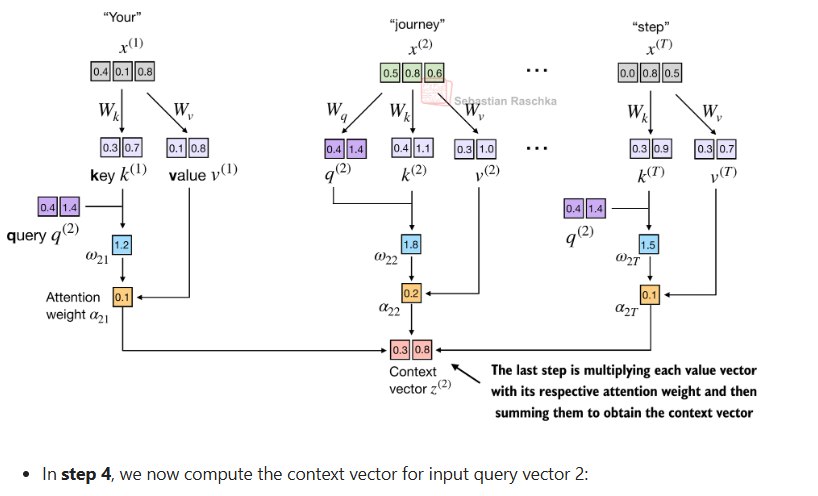

In [15]:
context_vec_2 = attention_weights_2 @ values
print(context_vec_2)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]])


<div class="alert alert-block alert-success">
    
So far, we only computed a single context vector, z(2). 

In the next section, we will generalize the code to compute all context vectors in the input sequence, z(1)to z (T)</div>

# Implementing a Compact Self Attention Python Class

<div class="alert alert-block alert-success">
    
In the previous sections, we have gone through a lot of steps to compute the self-attention
outputs. 

This was mainly done for illustration purposes so we could go through one step at
a time. 

In practice, with the LLM implementation in the next chapter in mind, it is helpful to
organize this code into a Python class as follows:
    
</div>

In [16]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attention_score = queries @ keys.T # omega
        attetnion_weight = torch.softmax(attention_score / keys.shape[-1]**0.5, dim = -1)

        context_vector = attetnion_weight @ values
        return context_vector
    

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


<div class="alert alert-block alert-warning">

In this PyTorch code, SelfAttention_v1 is a class derived from nn.Module, which is a
fundamental building block of PyTorch models, which provides necessary functionalities for
model layer creation and management.    
</div>

<div class="alert alert-block alert-warning">

The __init__ method initializes trainable weight matrices (W_query, W_key, and
W_value) for queries, keys, and values, each transforming the input dimension d_in to an
output dimension d_out.

</div>

<div class="alert alert-block alert-warning">

During the forward pass, using the forward method, we compute the attention scores
(attn_scores) by multiplying queries and keys, normalizing these scores using softmax.

</div>

<div class="alert alert-block alert-success">
    
Finally, we create a context vector by weighting the values with these normalized attention
scores.
    
</div>

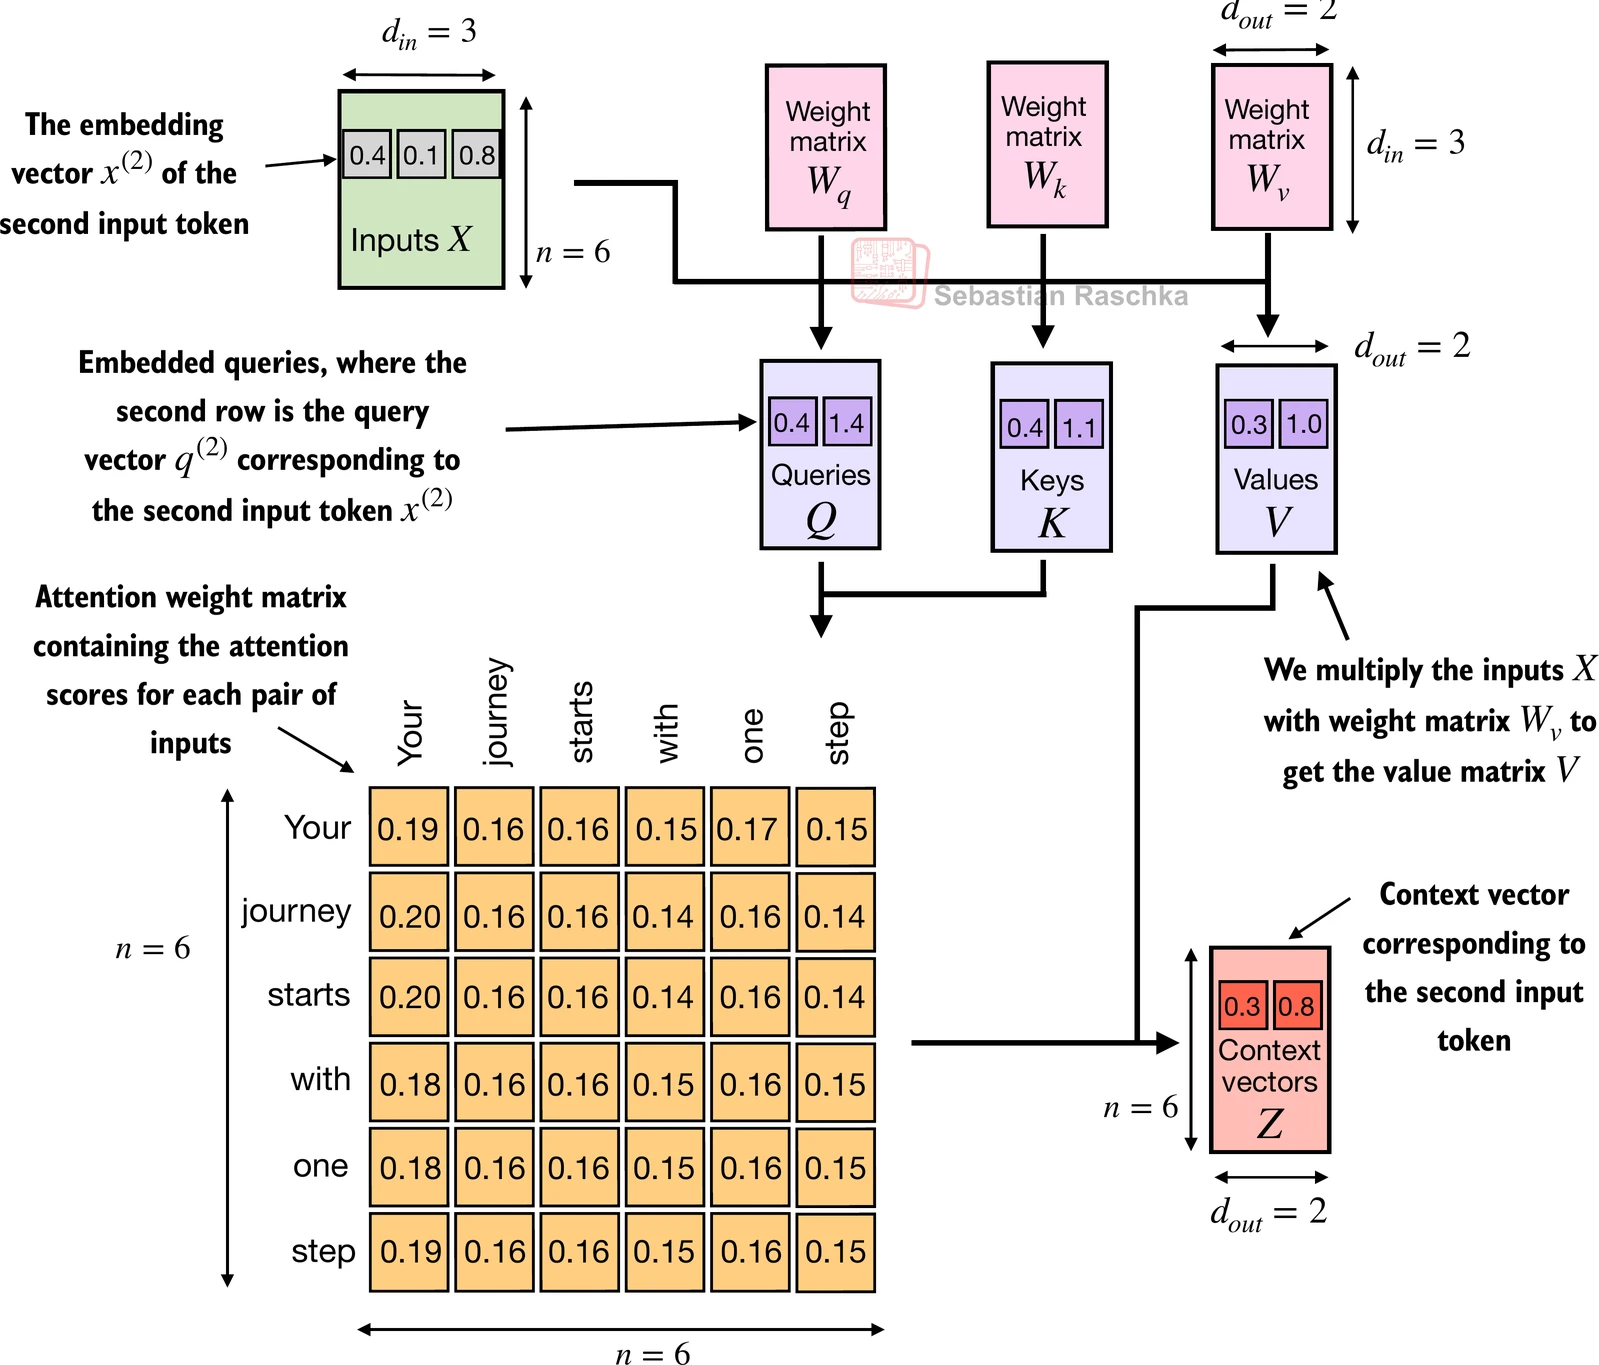

<div class="alert alert-block alert-info">

Since inputs contains six embedding vectors, we get a matrix storing the six
context vectors, as shown in the above result. 
</div>

<div class="alert alert-block alert-info">

As a quick check, notice how the second row ([0.3061, 0.8210]) matches the contents of
context_vec_2 in the previous section.
    
</div>

<div class="alert alert-block alert-warning">

We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's
nn.Linear layers, which effectively perform matrix multiplication when the bias units are
disabled. 

</div>

<div class="alert alert-block alert-warning">

Additionally, a significant advantage of using nn.Linear instead of manually
implementing nn.Parameter(torch.rand(...)) is that nn.Linear has an optimized weight
initialization scheme, contributing to more stable and effective model training.

</div>

In [17]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-success">

You can use the SelfAttention_v2 similar to SelfAttention_v1:
    
</div>

In [18]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


<div class="alert alert-block alert-info">

Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they
use different initial weights for the weight matrices since nn.Linear uses a more
sophisticated weight initialization scheme.
    
</div>